In [1]:
import re
import json
import pickle
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

In [3]:
def clean_str(s):
    return re.sub(r'\s', '', s)

def are_equal(a , b):
    return clean_str(a) == clean_str(b)

def a_in_b(a , b):
    return clean_str(a) in clean_str(b)

def add_cols (df, columns, default_value = 0):
    for k, e in enumerate(columns):
        i = common_data([e], df.columns, are_equal)

        if i == -1:
            df[e] = default_value
    return df

def common_data(list1, list2, comparisonf): 
    result = -1
  
    for k, x in enumerate(list1): 
        for y in list2: 
            
            if comparisonf(x,y):
                result = k
                return result  
                  
    return result

def prepare_data(df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3):
    
    for i in feat2dummie:
        one_hot = pd.get_dummies(df[i], prefix=i, drop_first=drop_first)
        df = df.drop(i,axis = 1)
        df = df.join(one_hot)

    is_recid, is_violent_recid = df['is_recid'], df['is_violent_recid']

    columns_to_drop = ['is_recid', 'is_violent_recid']
    df = df.drop(columns_to_drop, axis=1)
    
    dft = df.copy()

    for k,i in enumerate(cols_to_pow):
        for j in range(1, max_pow):
            dft[i+str(j+1)] = pow(df[i], j+1)
    
    dft = add_cols(dft, columns)
    
    return dft, is_recid, is_violent_recid

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data_folder = './data'
model_folder = './model'

train_dataset = 'train_compas_processed.xlsx'
validate_dataset = 'validate_compas_processed.xlsx'
model_colums_sample = 'model_colums_sample.xlsx'

model_file_name = 'rf_recidivism_prediction.sav'

### Load data

In [6]:
train_df_init = pd.read_excel (data_folder+'/'+train_dataset)
validate_df_init = pd.read_excel (data_folder+'/'+validate_dataset)

train_df = train_df_init
validate_df = validate_df_init

In [7]:
columns = pd.read_excel (data_folder+'/'+model_colums_sample).columns

In [8]:
train_df.shape

(8918, 14)

In [9]:
validate_df.shape

(470, 14)

#### Prepare data for prediction

In [10]:
max_pow = 3
drop_first = True

feat2dummie = ['sex','age_cat','race','c_charge_degree','c_cat','weapon_firearm']
cols_to_pow = ['age','decile_score','priors_count','juv_count']

validate_df_processed, is_recid, is_violent_recid = prepare_data(validate_df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3)

In [11]:
#df.shape

In [12]:
#df.head(10)

### Load model

In [13]:
rfc = pickle.load(open(model_folder+'/'+model_file_name, 'rb'))

In [14]:
train_df_processed, is_recid2, is_violent_recid2 = prepare_data(train_df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3)

train_df_processed['prediction'] = rfc.predict(train_df_processed)

In [15]:
train_df_processed.head(10)

,age,decile_score,priors_count,days_b_screening_arrest,c_days_from_compas,juv_count,sex_Male,age_cat_Greater than 45,age_cat_Less than 25,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M,c_cat_battery,c_cat_burglary,c_cat_cannabis,c_cat_driving,c_cat_grand theft,c_cat_lewdness,c_cat_mischief,c_cat_no charge,c_cat_other,c_cat_poss,c_cat_resisting,c_cat_sexual,c_cat_tampering,weapon_firearm_True,age2,age3,decile_score2,decile_score3,priors_count2,priors_count3,juv_count2,juv_count3,sex_Female,age_cat_25 - 45,race_African-American,c_charge_degree_F,c_cat_assault,weapon_firearm_False,prediction
0,40,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1600,64000,4,8,0,0,0,0,0,0,0,0,0,0,0
1,29,1,1,-1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,841,24389,1,1,1,1,1,1,0,0,0,0,0,0,0
2,23,5,0,-1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,529,12167,25,125,0,0,0,0,0,0,0,0,0,0,0
3,42,4,5,-1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1764,74088,16,64,25,125,0,0,0,0,0,0,0,0,0
4,24,4,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,576,13824,16,64,0,0,0,0,0,0,0,0,0,0,0
5,48,4,11,-1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2304,110592,16,64,121,1331,0,0,0,0,0,0,0,0,0
6,28,6,3,0,720,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,784,21952,36,216,9,27,0,0,0,0,0,0,0,0,0
7,27,1,0,-1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,729,19683,1,1,0,0,0,0,0,0,0,0,0,0,0
8,52,3,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2704,140608,9,27,0,0,0,0,0,0,0,0,0,0,0
9,38,8,0,-1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1444,54872,64,512,0,0,0,0,0,0,0,0,0,0,0


In [16]:
train_df['prediction'] = train_df_processed['prediction']

## 1. Bias detection in the data

Required data preprocessing. True labels should be in column `label_value`, predicted labels in column `score`. Any other column passed to `BiasDetection` class will be considered as protected property and statistical tests will be run on it

In [17]:
bias_df = train_df[['prediction', 'is_recid', 'race', 'sex', 'age_cat']]
bias_df = bias_df.rename(columns={'is_recid':'label_value', 'prediction':'score'})
bias_df.head()

,score,label_value,race,sex,age_cat
0,0,0,Caucasian,Female,25 - 45
1,0,0,Caucasian,Male,25 - 45
2,0,0,African-American,Male,Less than 25
3,0,0,Caucasian,Male,25 - 45
4,0,0,Caucasian,Male,Less than 25


In [18]:
import bias_detection.bias_detection as bd

bias = bd.BiasDetection(bias_df)

### Analysing dataset bias

First of all, we check the bias of a model and a dataset itself. For the dataset bias, we require that protected properties of an individual do not have a strong influence on the decision. That is, the library splits the dataset into groups based on protected property. If the percentage of positive labels is beyond [20% neighborhood](https://en.wikipedia.org/wiki/Disparate_impact) for all groups, then it is deemed to have a bias in respect to that protected property.

In [19]:
import pprint

dataset_bias_info = bias.check_dataset_bias()

pp = pprint.PrettyPrinter()
pp.pprint(dataset_bias_info)

{'details': {'age_cat': {'fair': False,
                         'ratios': {'25 - 45': 0.34568627450980394,
                                    'Greater than 45': 0.23864229765013054,
                                    'Less than 25': 0.42406726221755126}},
             'race': {'fair': False,
                      'ratios': {'African-American': 0.40582655826558267,
                                 'Asian': 0.20833333333333334,
                                 'Caucasian': 0.28391472868217055,
                                 'Hispanic': 0.2595907928388747,
                                 'Native American': 0.3333333333333333,
                                 'Other': 0.24074074074074073}},
             'sex': {'fair': True,
                     'ratios': {'Female': 0.2453551912568306,
                                'Male': 0.3637133182844244}}},
 'fair': False}


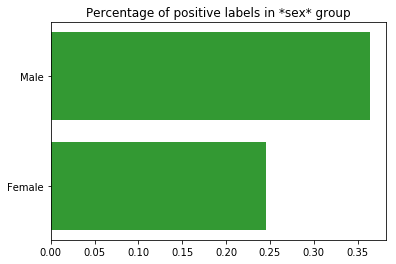

In [20]:
bias.plot_dataset_bias(dataset_bias_info, 'sex')

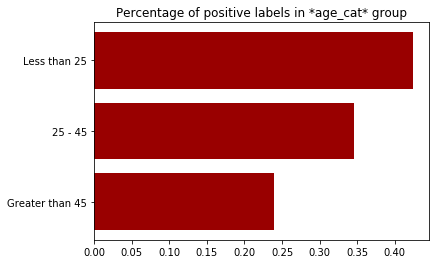

In [21]:
bias.plot_dataset_bias(dataset_bias_info, 'age_cat')

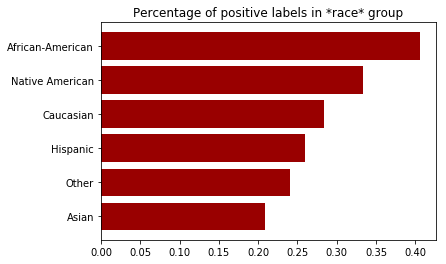

In [22]:
bias.plot_dataset_bias(dataset_bias_info, 'race')

### Analysing model bias

Now we analise the bias of the model itself. We can get bias summary with reqired level of detalization with `get_model_fairness` function. Available levels are `model`, `attribute`, and `value`. Each gives overview of fairness on model, attribute, and groups within each attribute (all kind of races) respectively

In [23]:
bias.get_model_fairness(level='model')

model_id, score_thresholds 1 {'rank_abs': [1]}
get_disparity_major_group()


{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [24]:
bias.get_model_fairness(level='attribute')

model_id, score_thresholds 1 {'rank_abs': [1]}
get_disparity_major_group()


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,True,False,False,True,NaN,True,True,NaN,False,False,False,False,False
1,1,binary 0/1,race,False,False,True,False,False,True,NaN,True,False,NaN,False,False,False,False,False
2,1,binary 0/1,sex,False,False,NaN,False,False,True,NaN,True,True,NaN,False,False,False,False,False


In [25]:
bias.get_model_fairness(level='value')

model_id, score_thresholds 1 {'rank_abs': [1]}
get_disparity_major_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,1,race,African-American,0.0,0.999620,0.405918,1.0,0.000380,1.0,0.594082,0.0,1,4427,1.0,0.000226,1,1797,2630,0,1797,2631,4428,8918,0.405827,1.0,1.0,NaN,1.0,1.000000,1.0,1.0,NaN,1.000000,1.000000,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,True,True,True,True,True,True,NaN,True,True,NaN,True,True,False,True,True
1,1,binary 0/1,1,race,Asian,0.0,1.000000,0.208333,NaN,0.000000,1.0,0.791667,NaN,0,48,0.0,0.000000,0,10,38,0,10,38,48,8918,0.208333,0.0,0.0,NaN,NaN,0.513240,0.0,1.0,NaN,1.000380,1.332589,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,False,False,NaN,False,False,True,NaN,True,False,NaN,False,False,False,False,False
2,1,binary 0/1,1,race,Caucasian,0.0,1.000000,0.283915,NaN,0.000000,1.0,0.716085,NaN,0,3096,0.0,0.000000,0,879,2217,0,879,2217,3096,8918,0.283915,0.0,0.0,NaN,NaN,0.699438,0.0,1.0,NaN,1.000380,1.205365,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,False,False,NaN,False,False,True,NaN,True,True,NaN,False,False,False,False,False
3,1,binary 0/1,1,race,Hispanic,0.0,1.000000,0.259591,NaN,0.000000,1.0,0.740409,NaN,0,782,0.0,0.000000,0,203,579,0,203,579,782,8918,0.259591,0.0,0.0,NaN,NaN,0.639515,0.0,1.0,NaN,1.000380,1.246309,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,False,False,NaN,False,False,True,NaN,True,True,NaN,False,False,False,False,False
4,1,binary 0/1,1,race,Native American,0.0,1.000000,0.333333,NaN,0.000000,1.0,0.666667,NaN,0,24,0.0,0.000000,0,8,16,0,8,16,24,8918,0.333333,0.0,0.0,NaN,NaN,0.821183,0.0,1.0,NaN,1.000380,1.122180,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,False,False,NaN,False,True,True,NaN,True,True,NaN,False,True,False,False,False
5,1,binary 0/1,1,race,Other,0.0,1.000000,0.240741,NaN,0.000000,1.0,0.759259,NaN,0,540,0.0,0.000000,0,130,410,0,130,410,540,8918,0.240741,0.0,0.0,NaN,NaN,0.593077,0.0,1.0,NaN,1.000380,1.278038,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,African-American,False,False,NaN,False,False,True,NaN,True,False,NaN,False,False,False,False,False
6,1,binary 0/1,1,sex,Female,0.0,0.999276,0.245489,1.0,0.000724,1.0,0.754511,0.0,1,1829,1.0,0.000546,1,449,1380,0,449,1381,1830,8918,0.245355,10.0,10.0,NaN,NaN,0.674953,10.0,1.0,NaN,0.999276,1.185803,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,False,False,NaN,False,False,True,NaN,True,True,NaN,False,False,False,False,False
7,1,binary 0/1,1,sex,Male,0.0,1.000000,0.363713,NaN,0.000000,1.0,0.636287,NaN,0,7088,0.0,0.000000,0,2578,4510,0,2578,4510,7088,8918,0.363713,NaN,NaN,NaN,NaN,1.000000,NaN,1.0,NaN,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male

Below we can see some useful visualization of fairness for `value` level with `plot_fairness` function. Red and green colors indicates which values are classified fairly by model and which aren't. There are two modes for visualization: with absolute and relative values respectively

model_id, score_thresholds 1 {'rank_abs': [1]}
get_disparity_major_group()


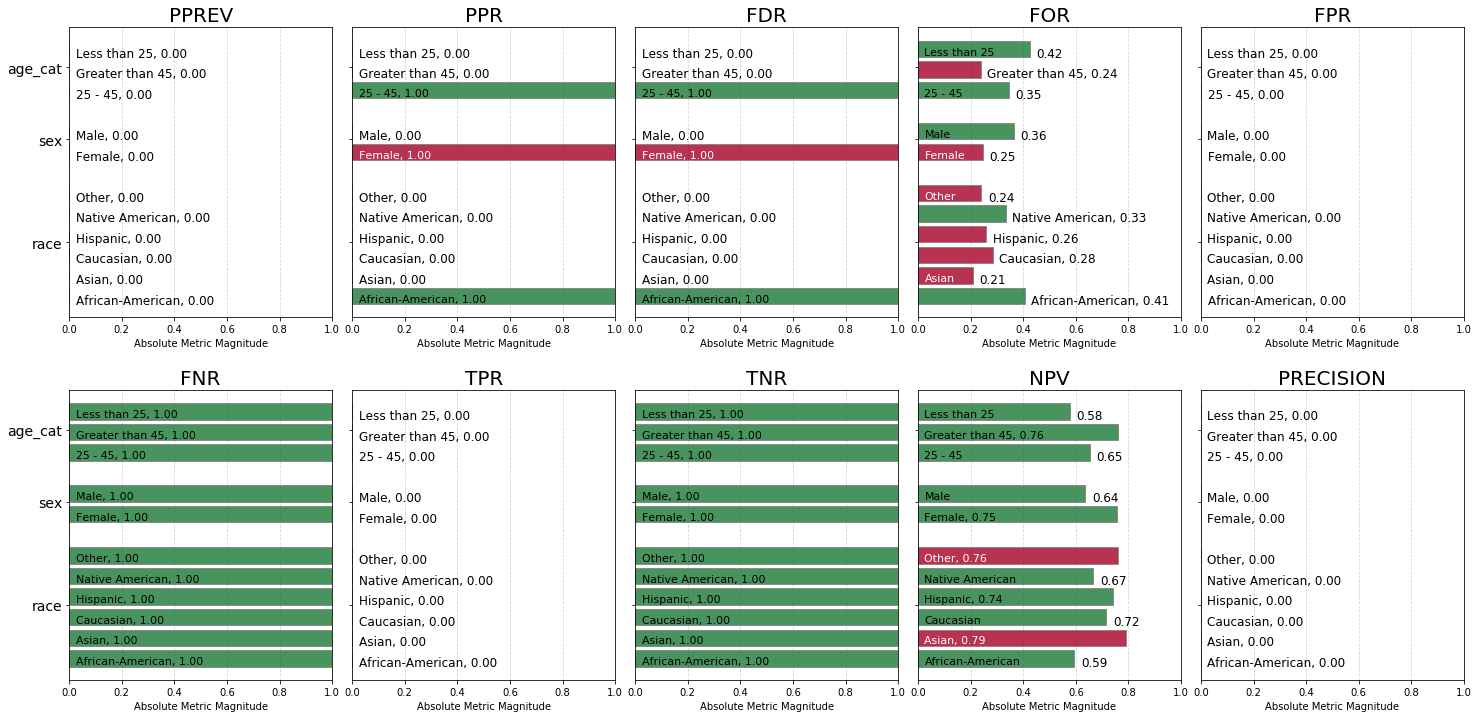

In [34]:
fg = bias.plot_fairness(is_absolute=True)

model_id, score_thresholds 1 {'rank_abs': [1]}
get_disparity_major_group()


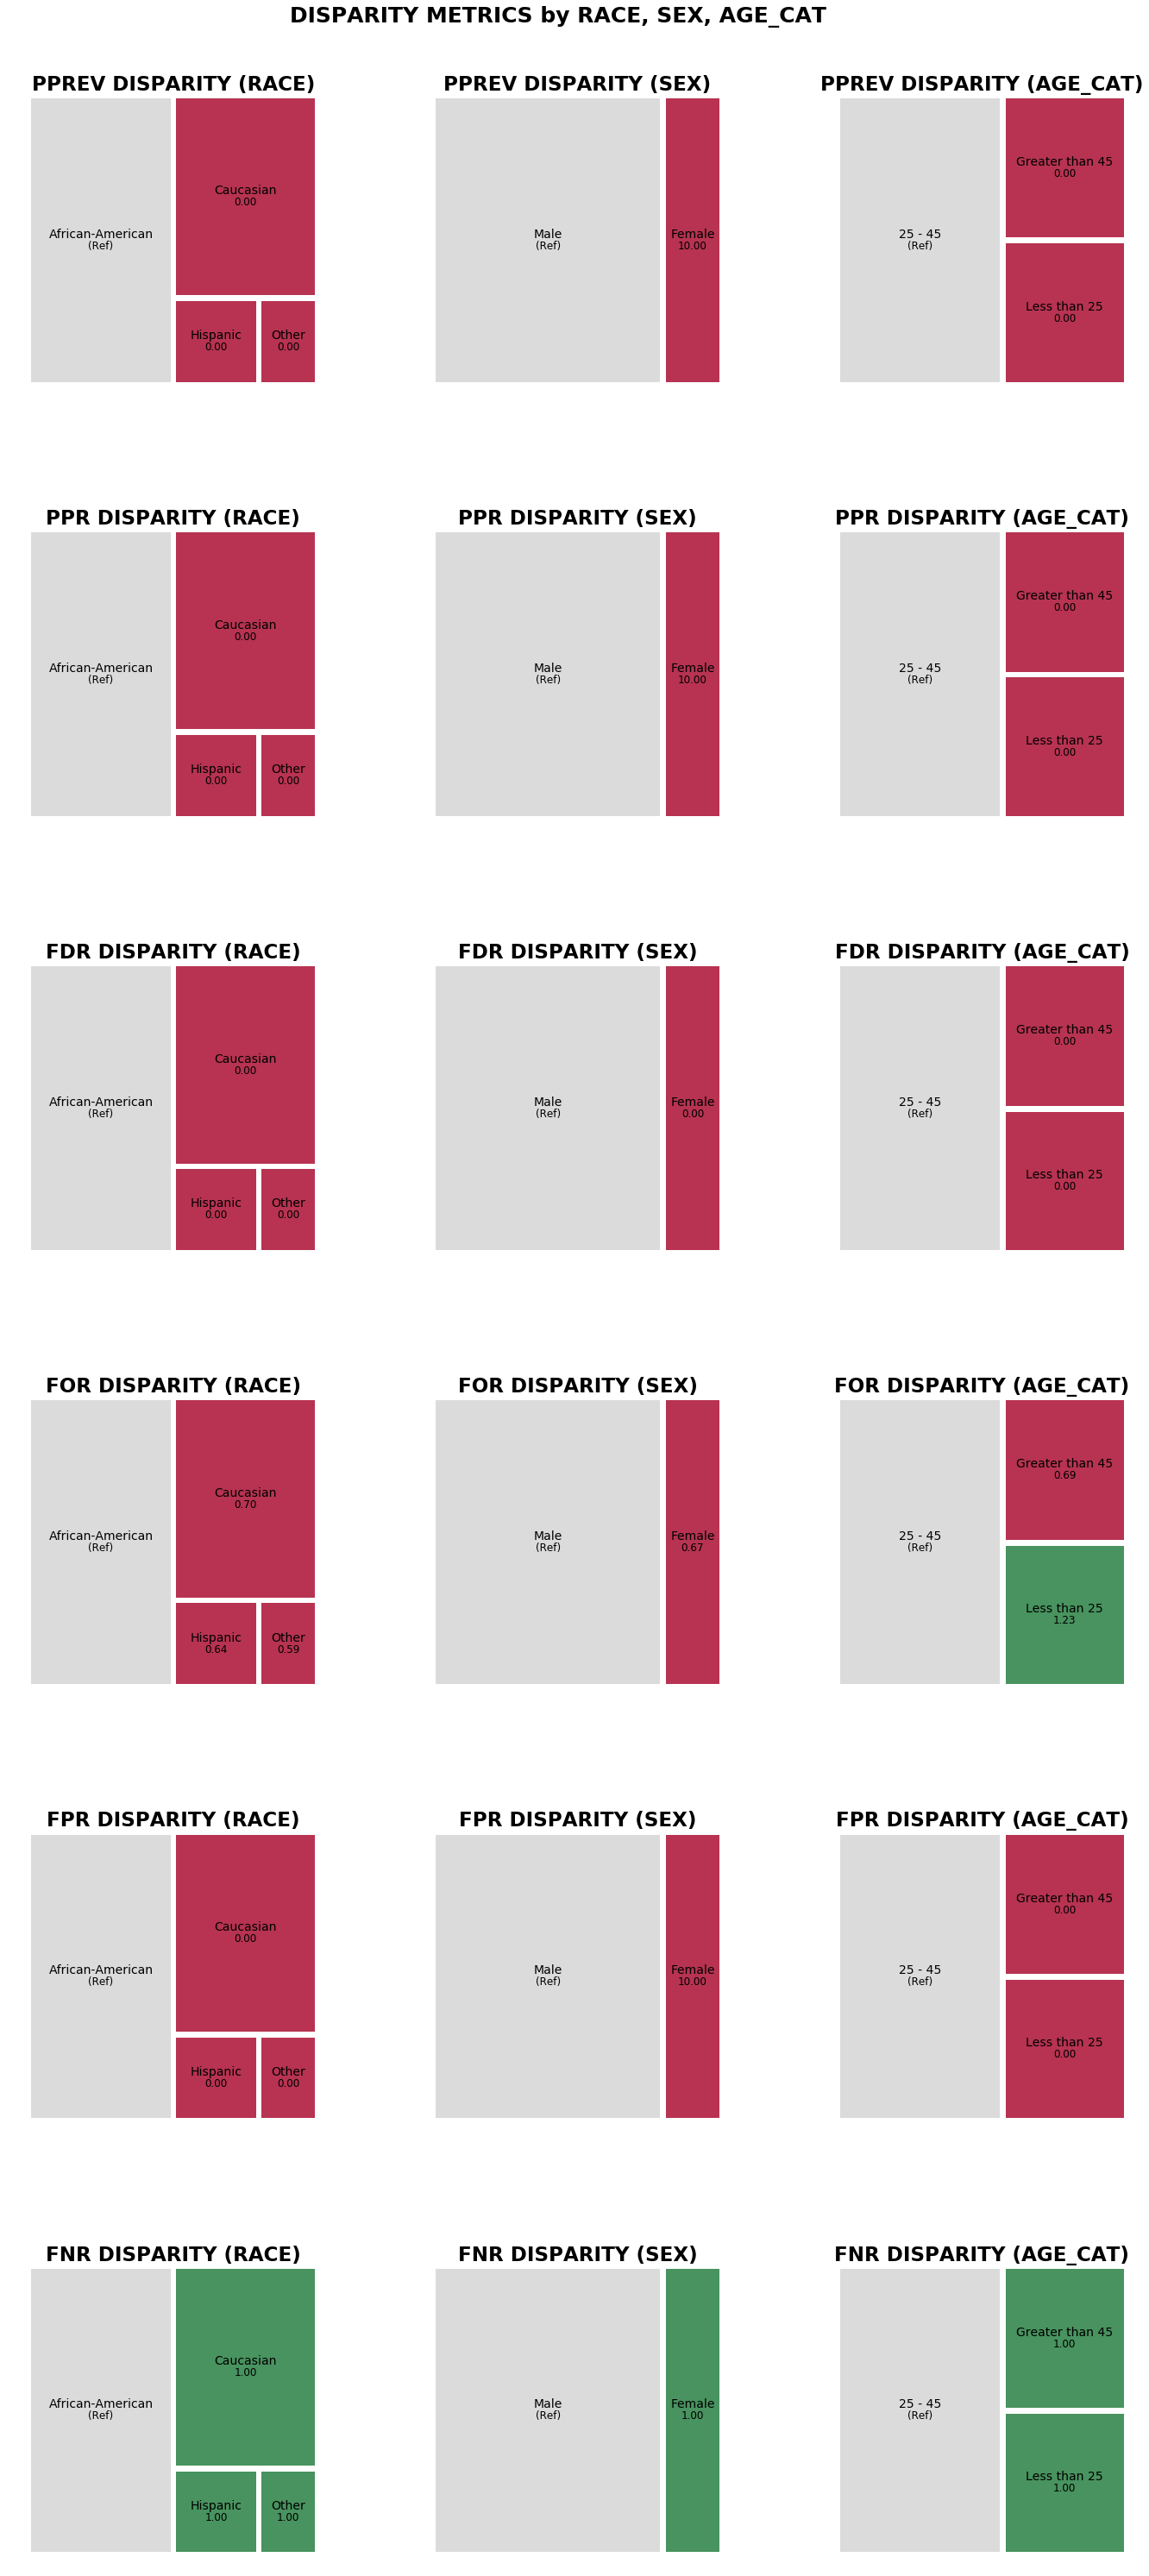

In [35]:
fg = bias.plot_fairness(is_absolute=False)

## 2. Feature selection from the data

### Oleg M

In [28]:
train_df.head()

,sex,age,age_cat,race,decile_score,priors_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,juv_count,c_cat,weapon_firearm,prediction
0,Female,40,25 - 45,Caucasian,2,0,0,0,F,0,0,0,poss,False,0
1,Male,29,25 - 45,Caucasian,1,1,-1,1,F,0,0,1,grand theft,False,0
2,Male,23,Less than 25,African-American,5,0,-1,1,F,0,0,0,cannabis,False,0
3,Male,42,25 - 45,Caucasian,4,5,-1,1,F,0,0,0,battery,False,0
4,Male,24,Less than 25,Caucasian,4,0,0,0,F,0,0,0,poss,False,0


In [29]:
train_df_processed.head()

,age,decile_score,priors_count,days_b_screening_arrest,c_days_from_compas,juv_count,sex_Male,age_cat_Greater than 45,age_cat_Less than 25,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M,c_cat_battery,c_cat_burglary,c_cat_cannabis,c_cat_driving,c_cat_grand theft,c_cat_lewdness,c_cat_mischief,c_cat_no charge,c_cat_other,c_cat_poss,c_cat_resisting,c_cat_sexual,c_cat_tampering,weapon_firearm_True,age2,age3,decile_score2,decile_score3,priors_count2,priors_count3,juv_count2,juv_count3,sex_Female,age_cat_25 - 45,race_African-American,c_charge_degree_F,c_cat_assault,weapon_firearm_False,prediction
0,40,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1600,64000,4,8,0,0,0,0,0,0,0,0,0,0,0
1,29,1,1,-1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,841,24389,1,1,1,1,1,1,0,0,0,0,0,0,0
2,23,5,0,-1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,529,12167,25,125,0,0,0,0,0,0,0,0,0,0,0
3,42,4,5,-1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1764,74088,16,64,25,125,0,0,0,0,0,0,0,0,0
4,24,4,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,576,13824,16,64,0,0,0,0,0,0,0,0,0,0,0


In [30]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

## 3. Result interpretability

### Valerii & Andrew

In [31]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [32]:
pred_result = rfc.predict(validate_df_processed)

In [33]:
result = roc_auc_score(is_recid, pred_result)

print(result)

0.5015120967741936
